In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import re
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from pandas import Series
import math
import os
from sklearn import preprocessing
import zipfile
import glob
import shutil
from pandas import Series, DataFrame
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,precision_score,recall_score,auc, roc_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import (LabelEncoder,OneHotEncoder, StandardScaler)  
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Embedding, Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.optimizers as optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
from sklearn import metrics

# Descargando la base de datos de descripciones

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alonsopuente","key":"a2490af4bf49c88fb2df45cdbad9784f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Cambiamos los permisos
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alonsopuente/kickstarter-projects-metadata
!kaggle datasets download -d alonsopuente/kickstarter-projects-descriptions
!kaggle datasets download -d srbhshinde/gloveicg
!ls

 86% 5.00M/5.78M [00:00<00:00, 20.0MB/s]
100% 5.78M/5.78M [00:00<00:00, 19.3MB/s]
 48% 17.0M/35.1M [00:00<00:00, 20.3MB/s]
100% 35.1M/35.1M [00:01<00:00, 34.5MB/s]
100% 1.64G/1.65G [00:37<00:00, 52.8MB/s]
100% 1.65G/1.65G [00:37<00:00, 46.6MB/s]
gloveicg.zip  kickstarter-projects-descriptions.zip  sample_data
kaggle.json   kickstarter-projects-metadata.zip


In [ ]:
os.mkdir('folder')
zip_train_test_md = zipfile.ZipFile('kickstarter-projects-metadata.zip','r')
zip_train_test_md.extractall()
zip_train_test_md.close()
zip_train_test_dsc = zipfile.ZipFile('kickstarter-projects-descriptions.zip','r')
zip_train_test_dsc.extractall()
zip_train_test_dsc.close()
zip_train_test_dsc = zipfile.ZipFile('gloveicg.zip','r')
zip_train_test_dsc.extractall()
zip_train_test_dsc.close()
os.rename('kickstarter-projects-metadata.zip','folder/kickstarter-projects-metadata.zip')
os.rename('kickstarter-projects-descriptions.zip','folder/kickstarter-projects-descriptions.zip')
os.rename('gloveicg.zip','folder/gloveicg.zip')
shutil.rmtree('folder')
shutil.rmtree('glove')

# Cargando la BD

In [ ]:
## configurar el ancho de la columna
pd.options.display.max_colwidth = 100
pd.options.display.max_colwidth

100

In [ ]:
metadata = pd.read_csv("Metadata.csv",sep = ',')
metadata.head(10)

,id,backers_count,name,blurb,category,photo,urls,city,country,goal,pledge_amounts,pledged,currency,usd_pledged,created_at,launched_at,deadline,duration,state
0,1000245024,0,Safer Home,"Placing furniture against traditional plugs is problematic and hazardous, my goal is to eliminat...",Hardware,https://ksr-ugc.imgix.net/assets/011/663/874/0d51c93f003e10b7fa539040ad0d7a21_original.gif?crop=...,https://www.kickstarter.com/projects/homesafety/safer-home?ref=category_newest,Kamloops,CA,50000.0,[10],0.0,CAD,0.000000,"March 09, 2014","June 03, 2015","July 03, 2015",30,failed
1,1000256230,0,Shreddit - Privacy on Reddit,"Shreddit, a Reddit privacy tool I created and have maintained for 4 years needs to become user f...",Software,https://ksr-ugc.imgix.net/assets/013/466/903/048a5685f8b72627381bcd365d08a162_original.png?ixlib...,https://www.kickstarter.com/projects/466914929/shreddit-privacy-on-reddit?ref=discovery_category...,Edinburgh,GB,2000.0,"[10, 25, 35, 50]",0.0,GBP,0.000000,"August 23, 2016","June 02, 2017","July 02, 2017",30,failed
2,1000261018,3,Diposta - liberating people from their postal mailbox.,"The problem of mail: it is physical! Diposta collects, digitizes, and provides daily postal mail...",Web,https://ksr-ugc.imgix.net/assets/012/071/808/109c2837de24229820849e9336054aba_original.jpg?ixlib...,https://www.kickstarter.com/projects/105350477/diposta-liberating-people-from-their-postal-mailb...,Raleigh,US,100000.0,"[40, 99, 199]",141.0,USD,141.000000,"March 17, 2015","July 24, 2016","August 23, 2016",30,failed
3,100039820,3,Best Spray Bottle Ever - SureShot,Ever had a spray bottle that has a little bit of fluid left in it and the siphon hose just won't...,Gadgets,https://ksr-ugc.imgix.net/assets/012/009/461/3859875d5cc367076b66279f444eeac9_original.jpg?ixlib...,https://www.kickstarter.com/projects/1101368489/best-spray-bottle-ever-sureshot?ref=category_newest,Edmonton,CA,25000.0,[10],3.0,CAD,2.411101,"January 22, 2015","February 05, 2015","March 07, 2015",30,failed
4,1000468345,6,The iRNinja - Simplify your TV with a wireless wall switch,Control your TV & Audio/Video components by pressing a button on the wall!!,Gadgets,https://ksr-ugc.imgix.net/assets/016/561/251/177076c636626b0502560747ae0830e0_original.jpg?ixlib...,https://www.kickstarter.com/projects/5877985/irninja-control-your-tv-with-a-simple-press-of-a-b?...,Jupiter,US,500.0,"[1, 10, 249, 300, 375, 425]",74.0,USD,74.000000,"April 27, 2017","May 10, 2017","June 14, 2017",35,failed
5,1000551777,12,Gantish - Online Reward Chart Creator for Parents,"Taking the novelty out of reward charts, and making them ACTUALLY work for you and your child!",Software,https://ksr-ugc.imgix.net/assets/012/223/719/4cae9a5f9cb4ed32cb54b0d601dbdcf9_original.jpg?ixlib...,https://www.kickstarter.com/projects/gantish/gantish?ref=discovery_category_newest,Mullingar,IE,4000.0,"[5, 10, 50]",282.0,EUR,313.300263,"August 13, 2015","August 17, 2015","September 16, 2015",30,failed
6,1000558429,1,Sellegg start up classified site,a simple and user freindly version of craigslist,Web,https://ksr-ugc.imgix.net/assets/012/393/161/0bd6bdf1b426233f1c8490a63bdb5129_original.png?ixlib...,https://www.kickstarter.com/projects/967612940/sellegg-start-up-classified-site?ref=discovery_ca...,Detroit,US,15000.0,"[25, 100]",25.0,USD,25.000000,"February 28, 2016","March 02, 2016","March 20, 2016",18,failed
7,1000590709,2,Musical Light Suit,"A Musical Light Suit that creates music on the fly depending on how you move in it, and lights u...",Hardware,https://ksr-ugc.imgix.net/assets/011/286/002/4639f87d2893bd3dc04d858374f69598_original.JPG?ixlib...,https://www.kickstarter.com/projects/905994053/musical-light-suit?ref=category_newest,Birmingham,US,6000.0,"[10, 200, 500]",20.0,USD,20.000000,"May 17, 2011","May 19, 2011","June 28, 2011",40,failed
8,1000624031,4,Hangar 1 Foundation,Seeking funding for the Hangar 1 Foundation so we can put up the 60 x 30 foot building we have a...,Flight,https://ksr-ugc.imgix.net/assets/011

In [ ]:
descripciones = pd.read_csv("data completa descripciones.csv",sep = ',')
descripciones = metadata.merge(descripciones, on='id', how='left', indicator=True)
descripciones = descripciones.reindex(columns=['id','description','state'])
descripciones.head(6)

,id,description,state
0,1000245024,Purpose Safer Home ensures that electrical plugs will not become a fire hazard. The invention co...,failed
1,1000256230,I once had a Reddit account that was four years old with thousands of comments forever stored in...,failed
2,1000261018,"Every day you go home to a mail box filled with junk and even worse, if you are a traveler it is...",failed
3,100039820,"Funds needed for tooling. Once tooling is done, approximately 30-45 days, bottle production can ...",failed
4,1000468345,The iRNinja is a wireless 4 button keypad that controls your entertainment system. It has two co...,failed
5,1000551777,"Gantish is a web-based platform for parents, where they can create beautifully designed reward c...",failed


# Análisis exploratorio

In [ ]:
#descripciones.loc[63]
descripciones[descripciones['description'].notnull()]

,id,description,state
0,1000245024,Purpose Safer Home ensures that electrical plugs will not become a fire hazard. The invention co...,failed
1,1000256230,I once had a Reddit account that was four years old with thousands of comments forever stored in...,failed
2,1000261018,"Every day you go home to a mail box filled with junk and even worse, if you are a traveler it is...",failed
3,100039820,"Funds needed for tooling. Once tooling is done, approximately 30-45 days, bottle production can ...",failed
4,1000468345,The iRNinja is a wireless 4 button keypad that controls your entertainment system. It has two co...,failed
...,...,...,...
27246,999630699,"What is No. 1 Fan? No.1 Fan is, among other things, a social network connecting people through t...",failed
27247,999630920,"https://www.youtube.com/watch?v=DB7HXP7_2nE Hi! In a nutshell, the goal, dream and purpose is to...",failed
27248,999748644,"Deep inside of the music and video production market; there are millions of creative rappers, po...",failed
27249,999753943,I have an idea “Parti Bash” to allow people to Bash or Host parties accessible through a mobile ...,failed


In [ ]:
print('Total de proyectos sin descripciones:',descripciones['description'].isnull().sum())
print('% proyectos sin descripciones:',round((descripciones['description'].isnull().sum()/len(descripciones['description']))*100,0))

Total de proyectos sin descripciones: 640
% proyectos sin descripciones: 2.0


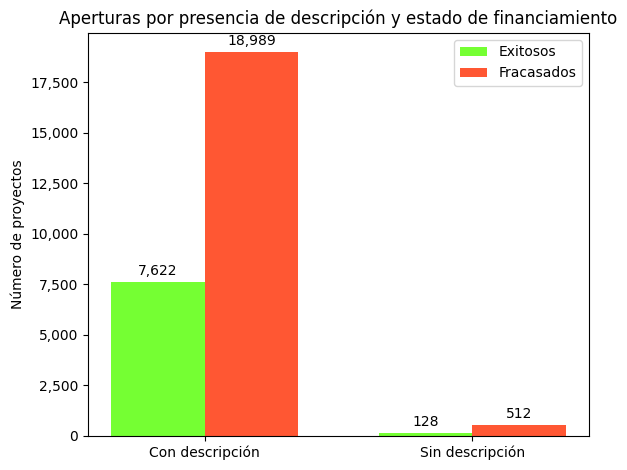

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de pie para estado de proyectos
# Fuente: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html?highlight=pie%20chart

plt.rcdefaults()

suc_sd = len(descripciones[(descripciones['state'] == 'successful') & (descripciones['description'].notnull())])
fai_sd = len(descripciones[(descripciones['state'] == 'failed') & (descripciones['description'].notnull())])
suc_nd = len(descripciones[(descripciones['state'] == 'successful') & (descripciones['description'].isnull())])
fai_nd = len(descripciones[(descripciones['state'] == 'failed') & (descripciones['description'].isnull())])
etiquetas = ['Con descripción','Sin descripción']

# Visualización de datos
# Fuente: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

x = np.arange(len(etiquetas))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [suc_sd, suc_nd], width, label='Exitosos', facecolor='#75FF33')
rects2 = ax.bar(x + width/2, [fai_sd, fai_nd], width, label='Fracasados', facecolor='#FF5733')


# Agregando las etiquetas y otros detalles a los ejes
ax.set_ylabel('Número de proyectos')
#ax.set_xlabel('Proyectos con y sin descripciones')
ax.set_title('Aperturas por presencia de descripción y estado de financiamiento')
ax.set_xticks(x)
ax.set_xticklabels(etiquetas)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))  #Para formatear los miles con comas
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig("projects description by state.png")
plt.show()

In [ ]:
projects_without_description = descripciones[descripciones['description'].isna()]
projects_without_description.groupby(['state']).size()

state
failed        512
successful    128
dtype: int64

# Pre-procesamiento de la data

In [ ]:
descripciones['description'][1]

"I once had a Reddit account that was four years old with thousands of comments forever stored in Reddit's archives, it was after considering and seeing examples of people being discovered and located (there are even websites that do it!) that I wrote a program to periodically go through posts I didn't want and to destroy them. Privacy is so important, the information people can garner just from going through your post history is astronomical. They can find where you live, what your hobbies are, where you went to school, university, how much money you make, and potentially even who you are. Some are okay with this. I'm not, and I believe it should be up to you. But while the tool I've written (https://github.com/x89/Shreddit) works well for me and other technically minded others, it's not viable for the vast majority — yet it could be. That's what this project is for, to create a website where you can control your Reddit history. You'll be the one in charge of how long your posts stay 

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', str(text))

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Removing URLs
    sentence = re.sub(r'https?://\S+', '', sentence) #remover urls
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [ ]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
X = []
sentences = list(descripciones['description'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
type(X[63])

str

In [ ]:
X[1]

'I once had Reddit account that was four years old with thousands of comments forever stored in Reddit archives it was after considering and seeing examples of people being discovered and located there are even websites that do it that wrote program to periodically go through posts didn want and to destroy them Privacy is so important the information people can garner just from going through your post history is astronomical They can find where you live what your hobbies are where you went to school university how much money you make and potentially even who you are Some are okay with this m not and believe it should be up to you But while the tool ve written works well for me and other technically minded others it not viable for the vast majority yet it could be That what this project is for to create website where you can control your Reddit history You ll be the one in charge of how long your posts stay alive for which subreddits you don mind your posts being on forever or which ind

# Separando en X & Y

In [ ]:
## Este párrafo adicional de código es para remover los stop words en inglés
lower_case = []
for tex in X:
    new_text = tex.lower()
    lower_case.append(new_text)

tokens = []
for text in lower_case:
    new_text = word_tokenize(text)
    tokens.append(new_text)
stop_words = set(stopwords.words('english'))

re_stopwords = []
for lista in tokens:
    not_stopwords = []
    for w in lista:
        if w not in stop_words:
            not_stopwords.append(w)
    re_stopwords.append(not_stopwords)

lemmatizer = WordNetLemmatizer()
lemmatization = []

for lista in re_stopwords:
    lemmas = []
  
    for w in lista:  
        word1 = lemmatizer.lemmatize(w, pos = "n")      #Lematizando con NLTK
        word2 = lemmatizer.lemmatize(word1, pos = "v")
        word3 = lemmatizer.lemmatize(word2, pos = ("a"))
        lemmas.append(word3)
        #new_text = lemmatize_with_postag(w)  #Lematizando con TextBlob
    
    lemmatization.append(lemmas)

text_clean = []
for lista in lemmatization:
    text = " ".join(lista).strip()
    text_clean.append(text)

X = text_clean
del lower_case
del tokens
del re_stopwords
del lemmatization
del text_clean

In [ ]:
X[1]

'reddit account four year old thousand comment forever store reddit archive consider see example people discover locate even website write program periodically go post want destroy privacy important information people garner go post history astronomical find live hobby go school university much money make potentially even okay believe tool write work well technically mind others viable vast majority yet could project create website control reddit history one charge long post stay alive subreddits mind post forever individual post submission want keep forever plan roughly follow research host server rent server purchase domain name set secure set monitor alert backup write frontend user management system logins preference reddit oauth rewrite shreddit utilise queue system tie web frontend test account test account close beta test limit number user kickstarter funders money ask pay development time pay host cost least year designer necessary ongoing commitment support provide good platfo

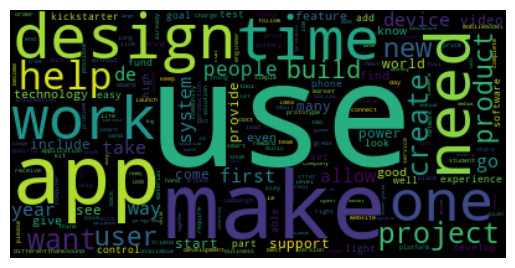

In [ ]:
# Solo para obtener la nube de palabras de la data original
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(X)
# Create a WordCloud object
#wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud = WordCloud(collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
#wordcloud.to_image()
plt.rcdefaults()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

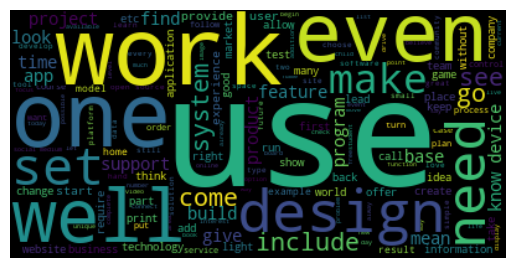

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(X)
# Create a WordCloud object
#wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud = WordCloud()
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.rcdefaults()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [ ]:
Y = descripciones['state']
Y = np.array(list(map(lambda x: 1 if x=="successful" else 0, Y)))

In [ ]:
Y[3]

0

# Separando en train y test

In [ ]:
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state=0)

In [ ]:
print(training_sentences[:5])
print(training_labels[:5])

['fran ai normal lisez cela attentivement english italic read carefully ce est pa possible qu il fasse degr en france en plein hiver la nature en marre et commence vraiment se cher contre nous le humains il faut limiter le g t moi aurai apport pierre dans ce combat en vue de limiter la gradation de notre plan te possible degree france middle winter nature feed start really get angry u human must limit damage bring stone fight limit degradation planet honn tement aurais bien pu choisir de continuer dans enseignement sup rieur comme enseignant chercheur que je suis aurais pu lancer une entreprise tr lucrative dans mon domaine expertise commerce et market aurais pu prendre un cdi dans une entreprise multinationale comme sp cialiste en big data toutefois je dis quoi bon courir apr de million euro si est pour vivre sur une plan te compl tement vast il fait degr en hiver et degr en alors je pr mettre me comp tences au profit une cause qui la fin permettra tout le monde de mieux vivre honestl

In [ ]:
embedding_dim = 100
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer(oov_token=oov_tok)
  tokenizer.fit_on_texts(lines)
  return tokenizer

tokenizer = create_tokenizer(training_sentences)

In [ ]:
# calculate the maximum document length (without stop words)
def max_length(lines):
  return max([len(s.split()) for s in lines])

# calculate max document length
length_long_sentence = max_length(training_sentences)
print('Max document length: %d' % length_long_sentence)
# Con stop words, el tamaño del vocabulario es 5152

Max document length: 3671


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# Con stop words, el tamaño del vocabulario es 165683

# Diccionario de palabras
word_index = tokenizer.word_index

Vocabulary size: 148270


In [ ]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
  # integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

# encode data
training_sentences = encode_text(tokenizer, training_sentences, length_long_sentence)
testing_sentences = encode_text(tokenizer, testing_sentences, length_long_sentence)

In [ ]:
training_sentences[3]

array([  16,  437, 3655, ...,    0,    0,    0], dtype=int32)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_sentences[3]))
#print(training_sentences[3])

create solar seeker design rotate motor would rotate degree design come help smc international able perfect design motor st rotate degree nd able pas power motor worry wire get tangle draw wire harness need transfer power solar panel battery electronics box next design frame design frame universal mount system allow people currently solar panel get solar seeker matter size panel could mount solar seeker want solar seeker last decade decide make frame high polish stainless steel project solar seeker revolutionary new dual axis solar track system small design powerful solar seeker revolve degree mount position track sun degree perfect alignment sun provide power possible solar seeker produce time power stationary panel solar seeker completely take rv home cabin business grid current solution power solar put lot panel roof play ping pong utility company sun shine excess power produce stationary panel sell utility company sun go get enough power solar buy power utility company major issue 

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('Glove/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_sentences[3]))

create solar seeker design rotate motor would rotate degree design come help smc international able perfect design motor st rotate degree nd able pas power motor worry wire get tangle draw wire harness need transfer power solar panel battery electronics box next design frame design frame universal mount system allow people currently solar panel get solar seeker matter size panel could mount solar seeker want solar seeker last decade decide make frame high polish stainless steel project solar seeker revolutionary new dual axis solar track system small design powerful solar seeker revolve degree mount position track sun degree perfect alignment sun provide power possible solar seeker produce time power stationary panel solar seeker completely take rv home cabin business grid current solution power solar put lot panel roof play ping pong utility company sun shine excess power produce stationary panel sell utility company sun go get enough power solar buy power utility company major issue 

In [ ]:
np.save('description_X_train.npy', training_sentences)
np.save('description_X_test.npy', testing_sentences)
np.save('description_Y_train.npy', training_labels)
np.save('description_Y_test.npy', testing_labels)

# Experimentación con diferentes modelos

In [ ]:
# Fuente de ideas:
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight('balanced', np.unique(Y), Y)
# Para que funcione correctamente los pesos de las clases balanceadas, se almacenan como diccionarios
class_weights = {i : class_weights[i] for i in range(2)}
print(class_weights)

{0: 0.6987077585764833, 1: 1.7581290322580645}


In [ ]:
# Fuentes:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://maelfabien.github.io/deeplearning/regu/#

# Para detener el entrenamiento cuando la pérdida en data de prueba empieza a subir. Límite de 2 incrementos.
# Para pérdida se usa mínimo. Para precisión se usa máximo
early_stopper = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

# Para reducir tasa de aprendizaje cuando es muy grande
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=5, verbose=1, min_delta=1e-4, mode='max')

## Red Neuronal Convolucional

In [ ]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
# Se tiene que dar acceso a Drive para almacenar el mejor modelo del checkpoint
# Fuente:
# https://medium.com/@mukesh.kumar43585/model-checkpoint-google-colab-and-drive-as-persistent-storage-for-long-training-runs-e35ffa0c33d9

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.callbacks import *
checkpoint_path_CNN ="/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_CNN_description2_model_epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint_CNN = ModelCheckpoint(filepath=checkpoint_path_CNN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=length_long_sentence, weights=[embedding_matrix],name="Embedding_description"),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(learning_rate= 1e-5, decay=1e-5)
model_cnn.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model_cnn.summary()
# Agregar batchnormalization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_description (Embed (None, 3671, 100)         14827000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3667, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,899,449
Trainable params: 14,899,449
Non-trainable params: 0
____________________________________________

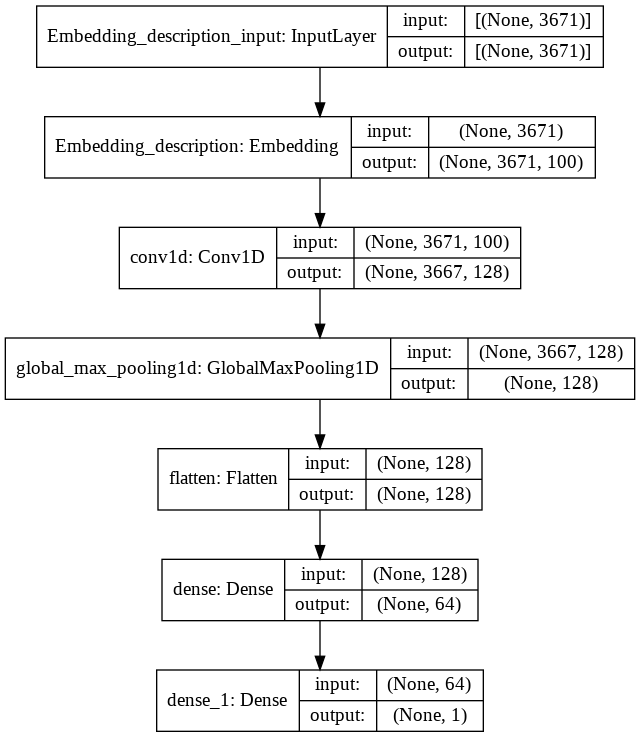

In [ ]:
plot_model(model_cnn, to_file='model_cnn_description.png', show_shapes=True, show_layer_names=True)

In [ ]:
start = datetime.now()

num_epochs = 100
batch_size = 128
hist_cnn = model_cnn.fit(training_sentences,
                 training_labels,
                 epochs=num_epochs,
                 batch_size=batch_size,
                 verbose=1,
                 validation_data=(testing_sentences, testing_labels),
                 class_weight=class_weights,
                 callbacks=[early_stopper, reduce_lr_acc, checkpoint_CNN],
                 shuffle=False)

stop=datetime.now()
execution_time_cnn = stop-start

Epoch 1/100
171/171 [==============================] - 107s 622ms/step - loss: 0.6822 - accuracy: 0.5155 - val_loss: 0.6604 - val_accuracy: 0.6292

Epoch 00001: val_loss improved from inf to 0.66042, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_CNN_description2_model_epochs:001-val_accuracy:0.629.hdf5
Epoch 2/100
171/171 [==============================] - 106s 622ms/step - loss: 0.6481 - accuracy: 0.6447 - val_loss: 0.6333 - val_accuracy: 0.6813

Epoch 00002: val_loss improved from 0.66042 to 0.63331, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_CNN_description2_model_epochs:002-val_accuracy:0.681.hdf5
Epoch 3/100
171/171 [==============================] - 106s 618ms/step - loss: 0.6241 - accuracy: 0.6820 - val_loss: 0.6134 - val_accuracy: 0.6984

Epoch 00003: val_loss improved from 0.63331 to 0.61343, saving model to /content/gdrive/My Drive/TESIS PARA EL TÍTULO - 

In [ ]:
# Cargamos los pesos del mejor modelo CNN
checkpoint_best_CNN_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Checkpoints/best_CNN_description2_model_epochs:072-val_accuracy:0.768.hdf5'
model_cnn.load_weights(checkpoint_best_CNN_path)

In [ ]:
score = model_cnn.evaluate(testing_sentences, testing_labels,verbose=1)
print('Test loss: ',score[0])
print('Test accuracy: ',score[1])

171/171 [==============================] - 7s 14ms/step - loss: 0.4837 - accuracy: 0.7740
Test loss:  0.4900865852832794
Test accuracy:  0.768299400806427


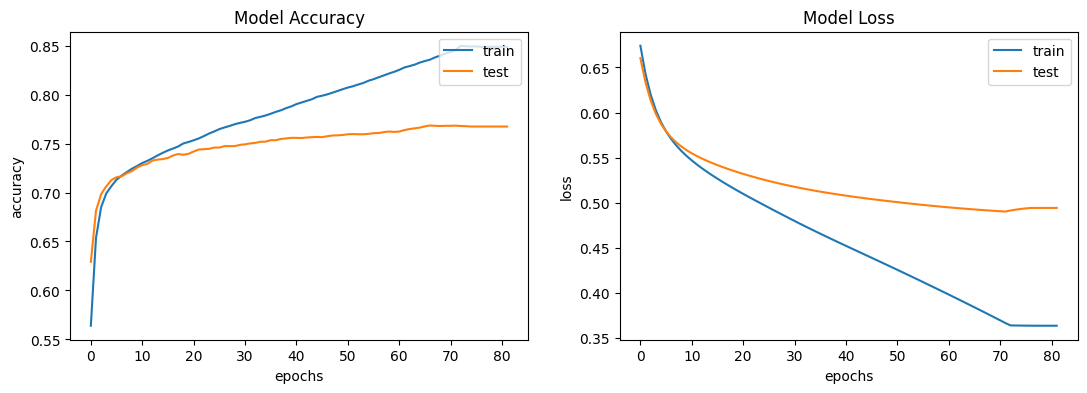

In [ ]:
plt.rcdefaults()

# summarize history for accuracy
fig = plt.figure(figsize=(13,4))
subfig = fig.add_subplot(121)
subfig.plot(hist_cnn.history['accuracy'])
subfig.plot(hist_cnn.history['val_accuracy'])
subfig.set_title('Model Accuracy')
subfig.set_ylabel('accuracy')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')

# summarize history for loss
subfig = fig.add_subplot(122)
subfig.plot(hist_cnn.history['loss'])
subfig.plot(hist_cnn.history['val_loss'])
subfig.set_title('Model Loss')
subfig.set_ylabel('loss')
subfig.set_xlabel('epochs')
subfig.legend(['train', 'test'], loc='upper right')
plt.show()

171/171 [==============================] - 6s 35ms/step


(2.5, -0.5)

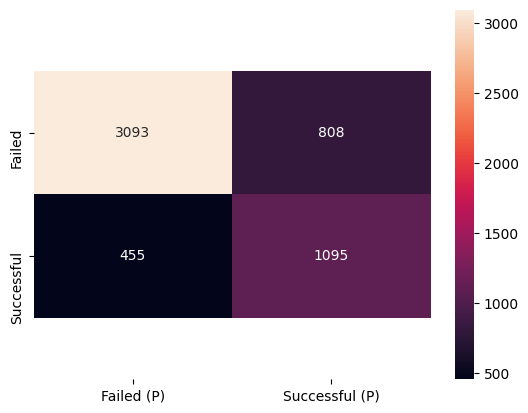

In [ ]:
labels_pred = model_cnn.predict([testing_sentences,testing_sentences,testing_sentences],verbose=1).ravel()
labels_pred = np.round(labels_pred)

conf_cnn = metrics.confusion_matrix(testing_labels, labels_pred, labels = [0,1])
label_y = ['Failed','Successful']
label_x = ['Failed (P)', 'Successful (P)']
ax_cnn = sns.heatmap(conf_cnn, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".0f")
bottom, top = ax_cnn.get_ylim()
ax_cnn.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
print('Classification Report')
target_names = ['Failed','Successful']
print(classification_report(testing_labels, labels_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Failed       0.87      0.79      0.83      3901
  Successful       0.58      0.71      0.63      1550

    accuracy                           0.77      5451
   macro avg       0.72      0.75      0.73      5451
weighted avg       0.79      0.77      0.77      5451



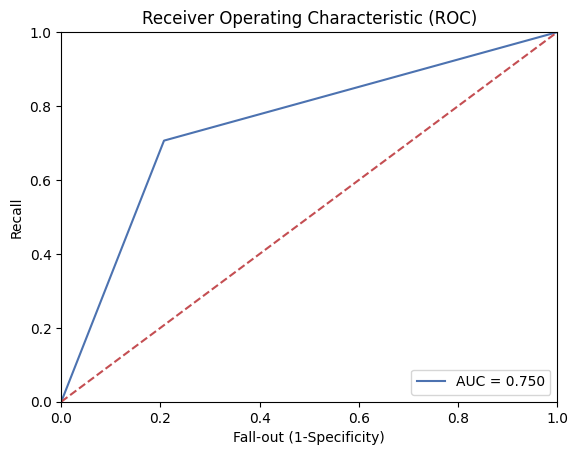

AUC score: 0.7496626175256965


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(testing_labels, labels_pred)
roc_auc_cnn = roc_auc_score(testing_labels,labels_pred)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_cnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc_cnn)

In [ ]:
e = model_cnn.layers[0]
weights_cnn = e.get_weights()[0]
print(weights_cnn.shape) # shape: (vocab_size, embedding_dim)

(148270, 100)


In [ ]:
# save the model to disk
best_cnn_model_path = '/content/gdrive/My Drive/TESIS PARA EL TÍTULO - ALONSO/Modelos guardados/Mejores/best_CNN_description_model.h5'
model_cnn.save(best_cnn_model_path)

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_description (Embed (None, 3671, 100)         14827000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3667, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,899,449
Trainable params: 14,899,449
Non-trainable params: 0
____________________________________________

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights_cnn[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluando modelos

## Tasa de aprendizaje

KeyboardInterrupt: ignored

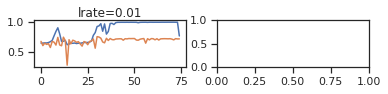

In [ ]:
# study of learning rate on accuracy for blobs problem
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, lrate):
	# define model
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=length_long_sentence))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  opt = SGD(lr=lrate)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	# fit model
  history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=75, class_weight=class_weights, verbose=0)
	# plot learning curves
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='test')
  pyplot.title('lrate='+str(lrate), pad=-50)

# create learning curves for different learning rates
learning_rates = [1E-2, 1E-3, 1E-4, 1E-5]
for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	fit_model(training_sentences, training_labels, testing_sentences, testing_labels, learning_rates[i])
# show learning curves
pyplot.show()

# Realizando predicciones

In [ ]:
# Probando con una descripción aleatoria
instance = X[9]
print(instance)

Hello Kickstarter We are excited to launch and share our first product the ODIN with the Kickstarter community With your help we will produce the first Android Smart projector that directly projects online content from compact battery operated device allowing sharing and viewing in unlimited ways We are thrilled with ODIN and we think you will be too We hope you will support our campaign with contributions and by spreading the word to your community ODIN is the ideal product for people who consume most of their entertainment using Netflix Hulu Amazon the web and mobile applications As we consume more information via the Internet we need compact portable device that gives us large visual display These are just some of the activities you can accomplish with ODIN We are sure that you will think of thousands of other ways Sometimes when problem offers no apparent answers the only solution is to radically alter the operating parameters After being continuously frustrated with paying for cab

In [ ]:
# Luego, se debe tokenizar todas las palabras previo a lanzar el modelo entrenado
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=length_long_sentence)

In [ ]:
# NN
nn_predict = model_nn.predict(instance)
nn_predict = 'Successful' if nn_predict[0][0] >= 0.5 else 'Failed'
print(nn_predict)

Successful


In [ ]:
descripciones['state'][9]

'successful'

In [ ]:
descripciones.head(16)

,id,description,state
0,1000245024,Purpose Safer Home ensures that electrical plugs will not become a fire hazard. The invention co...,failed
1,1000256230,I once had a Reddit account that was four years old with thousands of comments forever stored in...,failed
2,1000261018,"Every day you go home to a mail box filled with junk and even worse, if you are a traveler it is...",failed
3,100039820,"Funds needed for tooling. Once tooling is done, approximately 30-45 days, bottle production can ...",failed
4,1000468345,The iRNinja is a wireless 4 button keypad that controls your entertainment system. It has two co...,failed
5,1000551777,"Gantish is a web-based platform for parents, where they can create beautifully designed reward c...",failed
6,1000558429,"Hello, At SellEgg, our goal is to establish connections between the people who are selling vario...",failed
7,1000590709,I want to build a wearable Musical Light Suit that creates and responds to music. Visithttp://ww...,failed
8,1000624031,"Hello, my name is Kenneth Steenrod. I have been involved with the reenactment community since 19...",failed
9,1000629643,Hello Kickstarter! We are excited to launch and share our first product - the ODIN - with the Ki...,successful
